1. data cleaning

In [26]:
# 1.1 importing data and libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/nikgurunathan/Desktop/csv_heart/Heart.csv')

In [27]:
# 1.2 removing duplicates
df = df.drop_duplicates()
print(df.shape)

(444975, 40)


In [39]:
# 1.3 creating an Accurate Calculated BMI column
df['CalculatedBMI'] = df['WeightInKilograms'] / (df['HeightInMeters'] ** 2)

In [36]:
# 1.4 Logic checks

invalid_bmi = df[(df['BMI'] < 10) | (df['BMI'] > 80)]  # BMI typically ranges from 10 to 50
invalid_sleep = df[(df['SleepHours'] < 0) | (df['SleepHours'] > 24)]  # Sleep hours must be 0-24
suspicious_sleep_values = df[(df['SleepHours'] < 3) | (df['SleepHours'] > 22)] #maybe cap as outliers (?)


print(f"Invalid BMI entries: {len(invalid_bmi)}")
print(f"Invalid Sleep Hours entries: {len(invalid_sleep)}")
print(f"Suspicious sleep hours to check again: {len(suspicious_sleep_values)}")

# 1.4.1 ff AgeCategory is '65 or older', they should likely report having at least one of the following: 
#   heart attack, stroke, or diabetes
age_category_inconsistencies = df[
    (df['AgeCategory'] == '65 or older') &
    ~(df[['HadHeartAttack', 'HadStroke', 'HadDiabetes']].any(axis=1))
]
print(f"Number of logical inconsistencies in AgeCategory (age 65+ but no major health conditions): {len(age_category_inconsistencies)}")

# 1.4.2 if SmokerStatus is 'Yes', they should likely report at least one of the following:
#   heart attack, COPD, asthma, stroke
smoker_inconsistencies = df[
    (df['SmokerStatus'] == 'Yes') &
    ~(df[['HadHeartAttack', 'HadCOPD', 'HadAsthma', 'HadStroke']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in SmokerStatus (smoker but no major related health conditions): {len(smoker_inconsistencies)}")

# 1.4.3 if DifficultyWalking is True, then at least one of the following should also be True:
#   difficulty dressing and bathing, difficulty running errands
walking_inconsistencies = df[
    (df['DifficultyWalking'] == True) &
    ~(df[['DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in DifficultyWalking (difficulty walking but no related difficulties): {len(walking_inconsistencies)}")

# 1.4.4 if HadCOPD is True, then at least one of the following should also be True:
# difficulty walking, difficulty dressing and bathing, difficulty running errands
copd_inconsistencies = df[
    (df['HadCOPD'] == True) &
    ~(df[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in HadCOPD (COPD but no difficulties with daily activities): {len(copd_inconsistencies)}")

# 1.4.5 if HadHeartAttack is True, then at least one of the following should be True:
# stroke, angina, chest scan
heart_attack_inconsistencies = df[
    (df['HadHeartAttack'] == True) &
    ~(df[['HadStroke', 'HadAngina', 'ChestScan']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in HadHeartAttack (Heart Attack but no related conditions reported): {len(heart_attack_inconsistencies)}")

# 1.4.6 if SleepHours is less than 4 or more than 12, we expect at least one of the health conditions to be True:
# depressive disorder, heart attack, angina, stroke, skin cancer, asthma, COPD, kidney disease, arthritis, diabetes, difficulty concentrating, high risk last year
sleep_hours_inconsistencies = df[
    ((df['SleepHours'] < 5) | (df['SleepHours'] > 12)) &
    ~(df[['HadDepressiveDisorder', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadSkinCancer', 'HadAsthma', 'HadCOPD', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DifficultyConcentrating', 'HighRiskLastYear']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in SleepHours (abnormal sleep but no related health conditions): {len(sleep_hours_inconsistencies)}")

# 1.4.7 if PhysicalHealthDays is 0, they should not report significant limitations in daily activities
physical_health_inconsistencies = df[
    (df['PhysicalHealthDays'] == 0) &
    ~(df[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))]  # No difficulty reported
print(f"Number of logical inconsistencies in PhysicalHealthDays (0 health days but activity limitations): {len(physical_health_inconsistencies)}")



Invalid BMI entries: 80
Invalid Sleep Hours entries: 0
Suspicious sleep hours to check again: 2773
Number of logical inconsistencies in AgeCategory (age 65+ but no major health conditions): 0
Number of logical inconsistencies in SmokerStatus (smoker but no major related health conditions): 0
Number of logical inconsistencies in DifficultyWalking (difficulty walking but no related difficulties): 0
Number of logical inconsistencies in HadCOPD (COPD but no difficulties with daily activities): 0
Number of logical inconsistencies in HadHeartAttack (Heart Attack but no related conditions reported): 0
Number of logical inconsistencies in SleepHours (abnormal sleep but no related health conditions): 4
Number of logical inconsistencies in PhysicalHealthDays (0 health days but activity limitations): 14233


In [37]:
# 1.5 filling in missing values for numerical + object columns
df.fillna({col: df[col].median() for col in df.select_dtypes('float64')}, inplace=True)
df.fillna({col: df[col].mode().iloc[0] for col in df.select_dtypes('object')}, inplace=True)


print(df.isnull().sum()) #to check


State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     

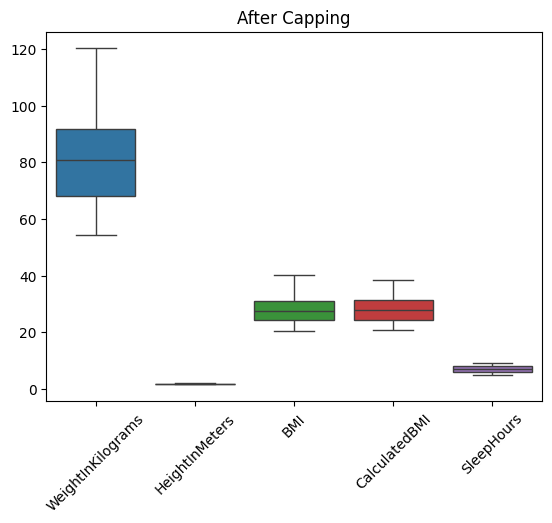

In [40]:
# 1.6 capping outliers
def cap_outliers(df, columns, lower_percentile=0.05, upper_percentile=0.95):
    for column in columns:
        lower_bound = df[column].quantile(lower_percentile)
        upper_bound = df[column].quantile(upper_percentile)
       
        # Apply capping
        df[column] = df[column].apply(lambda x: min(max(x, lower_bound), upper_bound))
   
    return df


# 1.6.1 list of columns to cap
columns_to_cap = ['WeightInKilograms', 'HeightInMeters', 'BMI', 'CalculatedBMI', 'SleepHours']


# 1.6.2 applying the capping
df_cleaned = cap_outliers(df, columns_to_cap)


# 1.6.3 verification of capping
sns.boxplot(data=df[columns_to_cap])
plt.title("After Capping")
plt.xticks(rotation=45)
plt.show()


In [41]:
# 1.7 cleaning and standardizing text data
for col in df.select_dtypes(include=['category', 'object']).columns:
    df[col] = df[col].str.strip().str.lower()

In [42]:
dataframe = df.drop_duplicates()


In [56]:
dataframe.to_csv('Heart_cleaned.csv', index=False)

2. preparing data for the model

In [57]:
dataframe = pd.read_csv('/Users/nikgurunathan/Desktop/csv_heart/Heart_cleaned.csv')

In [49]:
# converting yes/no columns to numeric
def yes_no_to_binary(entry):
    if entry == 'yes':
        return 1
    elif entry == 'no':
        return 0
    elif entry == 'no, pre-diabetes or borderline diabetes':
        return 0.5

dataframe = dataframe.applymap(lambda x: yes_no_to_binary(x) if x in ['yes', 'no', 'no, pre-diabetes or borderline diabetes'] else x)

# initialising the total risk score column
dataframe['RiskScore'] = 0

# run cell 10 again after this 
# see list below for health/lifestyle risk factors ranked from most to least disruptive to daily life

/var/folders/qn/4dpq089x26d0h5p0v709glyw0000gn/T/ipykernel_28220/1378392429.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframe = dataframe.applymap(lambda x: yes_no_to_binary(x) if x in ['yes', 'no', 'no, pre-diabetes or borderline diabetes'] else x)


from most to least disruptive:
* stroke = 10 pts
* heart attack = 9.5 pts
* COPD = 9 pts
* depressive disorder = 8.5 pts
* blind / vision difficulty = 8.5 pts
* difficulty dressing and bathing = 8.5 pts
* angina = 8 pts
* arthritis = 7.5 pts
* kidney disease = 7.5 pts
* difficulty concentrating = 7 pts
* diabetes = 7 pts
* asthma = 6.5 pts
* difficulty running errands = 6 pts
* deaf / hard of hearing = 6 pts
* skin cancer = 5.5 pts
* calculated bmi < 18.5 - 5 pts
* calculated bmi > 24.9 = 4.5 pts 
(bmi normal range is 18.5-24.9)
* smoker status: current smoker - now smokes every day = 4.5 pts
* e-cigarette usage - use them every day = 4 pts
* smoker status: current smoker - now smokes some days = 3.5 pts
* e-cigarette usage: use them some days - 3 pts
* smoker status: former smoker = 2.5 pts
* e-cigarette usage: not at all (right now) = 2 pts
* smoker status: never smoked = 2 pts
* e-cigarette usage: never used e-cigarettes in my entire life = 2 pts
* alcohol drinkers = 2 pts
* sleep hours < 7 hours = 1.5 pts

In [55]:
dataframe.drop(columns=['TotalRiskScore', 'HeartAttackRisk', 'COPDRisk', 'BlindRisk', 'DepressiveRisk', 'WalkingRisk', 'KidneyRisk', 'DiabetesRisk', 'SkinCancerRisk', 'DeafRisk', 'SmokerPoints', 'ECigPoints'])

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,CalculatedBMI,RiskScore
0,alabama,female,very good,0.0,0.0,within past year (anytime less than 12 months ...,0,8.0,none of them,0,...,27.44,0,0,1,0,"yes, received tetanus shot but not sure what type",0,0,27.353965,0
1,alabama,female,excellent,0.0,0.0,within past year (anytime less than 12 months ...,0,6.0,none of them,0,...,26.57,0,0,0,0,"no, did not receive any tetanus shot in the pa...",0,0,26.578125,0
2,alabama,female,very good,2.0,3.0,within past year (anytime less than 12 months ...,1,5.0,none of them,0,...,25.61,0,0,0,0,"no, did not receive any tetanus shot in the pa...",0,1,25.761694,0
3,alabama,female,excellent,0.0,0.0,within past year (anytime less than 12 months ...,1,7.0,none of them,0,...,23.30,0,0,1,1,"no, did not receive any tetanus shot in the pa...",0,0,23.324151,0
4,alabama,female,fair,2.0,0.0,within past year (anytime less than 12 months ...,1,9.0,none of them,0,...,21.77,1,0,0,1,"no, did not receive any tetanus shot in the pa...",0,0,21.899469,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444757,virgin islands,female,good,0.0,3.0,within past 2 years (1 year but less than 2 ye...,1,6.0,none of them,0,...,25.63,1,1,0,0,"no, did not receive any tetanus shot in the pa...",0,1,25.656566,0
444758,virgin islands,female,excellent,2.0,2.0,within past year (anytime less than 12 months ...,1,7.0,none of them,0,...,28.66,0,1,1,0,"yes, received tetanus shot but not sure what type",0,0,28.723183,0
444759,virgin islands,female,poor,30.0,30.0,5 or more years ago,0,5.0,1 to 5,0,...,20.36,1,0,0,0,"no, did not receive any tetanus shot in the pa...",0,0,20.356063,0
444760,virgin islands,male,very good,0.0,0.0,within past year (anytime less than 12 months ...,0,5.0,none of them,1,...,32.55,0,1,1,1,"no, did not receive any tetanus shot in the pa...",0,1,32.506196,0


In [52]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (10 * dataframe['HadStroke'])

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,BlindRisk,DepressiveRisk,WalkingRisk,KidneyRisk,DiabetesRisk,SkinCancerRisk,DeafRisk,SmokerPoints,ECigPoints,RiskScore
0,alabama,female,very good,0.0,0.0,within past year (anytime less than 12 months ...,0,8.0,none of them,0,...,0,0,0,0,3.0,0,0,0,1,0
1,alabama,female,excellent,0.0,0.0,within past year (anytime less than 12 months ...,0,6.0,none of them,0,...,0,0,0,0,0.0,2,0,0,0,0
2,alabama,female,very good,2.0,3.0,within past year (anytime less than 12 months ...,1,5.0,none of them,0,...,0,0,0,0,0.0,2,0,0,0,0
3,alabama,female,excellent,0.0,0.0,within past year (anytime less than 12 months ...,1,7.0,none of them,0,...,0,0,0,0,0.0,0,0,2,0,0
4,alabama,female,fair,2.0,0.0,within past year (anytime less than 12 months ...,1,9.0,none of them,0,...,0,0,0,0,0.0,0,0,0,0,0
